<a href="https://colab.research.google.com/github/AbbyNyakara/Mushroom-Classification/blob/main/STT_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mushroom Image Classification Project

# Team:
- Peter Imoukhuede
- Ezequiel Mussambe
- Abigael Mogusu




# PART 1 - Setup and Load data

In [51]:
# Import dependancies:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt


In [2]:
# No gpu connected?? yikes
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Setup GPU memory consumption growth: Avoid the OOM error:

# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#   tf.config.experimental.set_memory_growth(gpu, True)


#### Load the data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [34]:
# Load data
# The classes of the data depends on the folder name

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Statistics/Project/Dataset',
    batch_size=32
    )

Found 28759 files belonging to 2 classes.


## PART 2. DATA PREPROCESSING:
- Split the data
- Resize the images
- Normalize the Images
- Data Augmentation for edible class to be done on the fly as at the training

In [17]:
# Training set (70% of the data)
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.20,
#     subset="training",
#     seed=123
# )

# # Validation set( 15% of the data)
# validation_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.20,
#     subset="validation",
#     seed=123
# )

# # Testing set(15% of the data)
# test_ds = tf.keras.utils.image_dataset_from_directory(
#     '/content/drive/MyDrive/Statistics/Project/Dataset',
#     validation_split=0.15,
#     subset="testing",
#     seed=123
# )



Found 28759 files belonging to 2 classes.
Using 23008 files for training.
Found 28759 files belonging to 2 classes.
Using 5751 files for validation.


## Shuffle the images before actually dividing??

In [36]:
# Alternatively:
train_size = int(len(dataset)*0.7)
test_size = int(len(dataset)*0.15)+1
validation_size = int(len(dataset)*0.15)+1



In [41]:
# Now split the data:

train_ds = dataset.take(train_size)
test_ds = dataset.skip(train_size).take(test_size)
val_ds = dataset.skip(train_size+test_size).take(validation_size)

len(train)
# The train is about 629 batches

629

In [42]:

# Print the classNames:
class_names = dataset.class_names
print(class_names)

['Edible Mushrooms', 'Inedible Mushrooms']


In [55]:
# 1. Resize the images:

size = (256, 256)

# Use a labda function to resize all the images for both the training and validatioon sets:
train_ds1 = train_ds.map(lambda image, label:(tf.image.resize(image, size), label))
validation_ds1 = val_ds.map(lambda image, label:(tf.image.resize(image, size), label))

In [56]:
# Normalize the images to a common value:
train_ds = train_ds1.map(lambda image, label: (image/255.0, label))
validation_ds = validation_ds1.map(lambda image, label: (image/255.0, label))


# 3. Exploratory Data Analysis (EDA)

- Check for any outliers in the images
- Display a few random images
- Imbalances in the data:

## 3.1 Display the images:

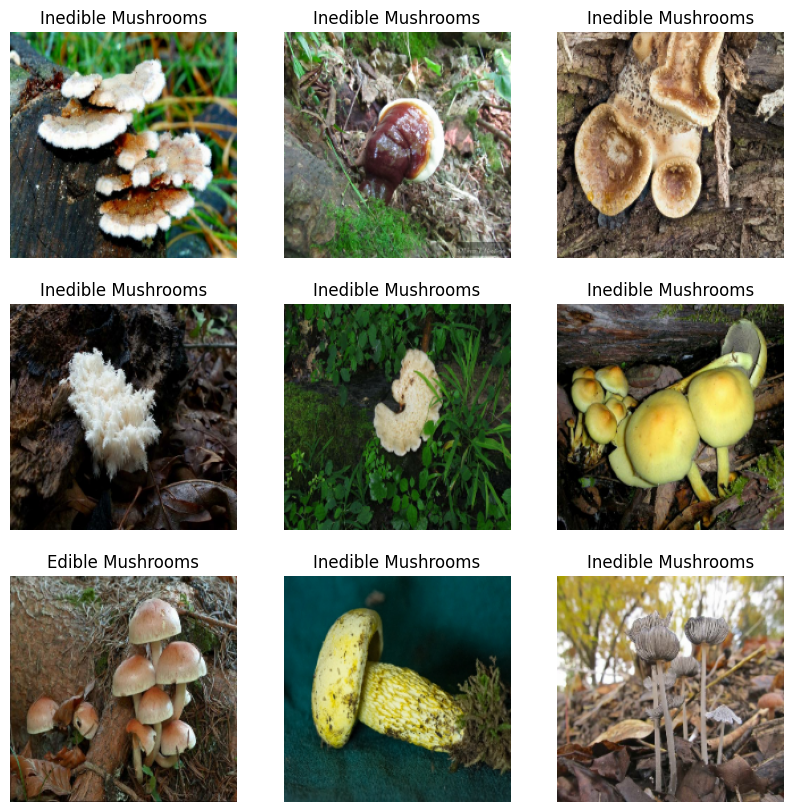

In [48]:
# Display original images :

# The dataset is very highly imbalanced. Only picking the inedbile images??
plt.figure(figsize=(10, 10))
for images, labels in train_ds1.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

## 3.2 Check for outliers

In [49]:

pixel_sums = 0
pixel_sums_squared = 0
num_samples = 0

# Iterate over unbatched dataset to calculate mean and std
for images, _ in train_ds.unbatch():
  pixel_sums += tf.reduce_sum(images, axis=[0, 1, 2])
  pixel_sums_squared += tf.reduce_sum(tf.square(images), axis=[0, 1, 2])
  num_samples += images.shape[0]

# Calculate mean and standard deviation
mean = pixel_sums / num_samples
std = tf.sqrt((pixel_sums_squared / num_samples) - tf.square(mean))

# Define a function to detect outliers
def is_outlier(image, mean, std, threshold=3):
    distance_from_mean = tf.abs(image - mean)
    return tf.reduce_any(distance_from_mean > (threshold * std))

# Collect outliers
outliers = [(image, label) for image, label in train_ds.unbatch() if is_outlier(image, mean, std)]

# Print the number of outliers
print(f"Number of outlier images: {len(outliers)}")

# Visualize outliers
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(outliers[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Label: {class_names[label]}")
    plt.axis("off")
plt.show()


KeyboardInterrupt: 

## 3.3 Checking for imbalances in the data:

In [ ]:
# Check number of images in each class/ imbalances in the data:

class_counts = {}
for images, labels in dataset:
  for label in labels:
    class_name = class_names[label]
    if class_name not in class_counts:
      class_counts[class_name] = 0
    class_counts[class_name] += 1

for class_name, count in class_counts.items():
  print(f"Class: {class_name}, Count: {count}")

# 4. Convolutional Neural Network Model:

## 4.1 Build the deep learning model

In [57]:
# Define the model:
model = Sequential()

In [58]:
# Add the layers:

model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation="relu" ))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))


In [59]:
# Compile the model:
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [60]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)       

## 4.2 Train the model:

In [61]:
log_directory = '/content/drive/MyDrive/Statistics/Project/logs'

In [66]:
# This is to log the model as it trains: (To check how it performs as it trains)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_directory)

In [ ]:
hist = model.fit(train_ds, epochs=20, validation_data = val_ds, callbacks=tensorboard_callback)

Epoch 1/20
101/629 [===>..........................] - ETA: 31:53 - loss: 0.5400 - accuracy: 0.7856